<a href="https://colab.research.google.com/github/binliu0630/Deep_Learning/blob/master/Fastai_with_RoBERTa_for_Classification_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 46.2MB/s 
     |████████████████████████████████| 808kB 51.3MB/s 
     |████████████████████████████████| 1.0MB 47.1MB/s 
     |████████████████████████████████| 655kB 52.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.33-cp36-none-any.whl size=833106 sha256=fbb4b96ffd96fde69c088064811ac97335ed754ad26ec7bf374c1fb028a6922c
  Stored in directory: /root/.cache/pip/wheels/70/87/56/e40575cca30d12fee8875d523b8878b7aba866a9f03b2fd983
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609222 sha256=8e04071b9ad36cdd3afcc1858b8a9be96db79e95c0a7ef900da0f870b651861c
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built sacremoses regex


In [9]:
pip install fastai

In [0]:
import pandas as pd

In [0]:
url = 'https://raw.githubusercontent.com/devkosal/fastai_roberta/master/fastai_roberta_imdb/imdb_dataset.csv'
data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
from fastai.text import *
from fastai.metrics import *
from pytorch_transformers import RobertaTokenizer

In [0]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2019,
    roberta_model_name='roberta-base', # can also be exchnaged with roberta-large 
    max_lr=1e-5,
    epochs=1,
    use_fp16=False,
    bs=4, 
    max_seq_len=256, 
    num_labels = 2,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)

In [0]:
feat_cols = "review"
label_cols = "sentiment"

SET UP TOKENIZER

In [0]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

In [12]:
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

100%|██████████| 456318/456318 [00:00<00:00, 533163.19B/s]


In [0]:
# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [0]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

SET UP DATABUNCH

In [0]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [0]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [0]:
# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

# creating our databunch 
data = RobertaTextList.from_df(data, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)

BUILDING THE MODEL

In [0]:
import torch
import torch.nn as nn
from pytorch_transformers import RobertaModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=2):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits

In [19]:
roberta_model = CustomRobertaModel(num_labels=config.num_labels)

learn = Learner(data, roberta_model, metrics=[accuracy])

100%|██████████| 501200538/501200538 [00:43<00:00, 11584418.04B/s]


In [20]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.198077,0.154746,0.942600,39:15


In [0]:
learn = learn.to_fp16()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


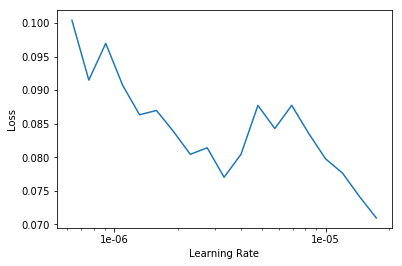

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(2, 3e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.221473,0.199842,0.924400,24:58
1,0.088046,0.177468,0.939900,24:57


GETTING PREDICTION

In [0]:

def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [0]:
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [23]:
# accuracy on valid
(pred_values == data.valid_ds.y.items).mean()

0.9426

Reference: 
https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c